# Using VADER in a Multinomial Logistic Regression Model

### Getting Started

To use these libraries you need to make sure you have the appropriate packages
<br>
installed on your machine. The libraries used in this guide are pandas, vaderSentiment, mlxtend, langdetect, sklearn, and nltk 
<br>
Run the following commands on the command line to install these libraries:
- pip install pandas
- pip install vaderSentiment
- pip install mlxtend
- pip install langdetect
- pip install sklearn
- pip install nltk

You may also need to run these lines of code in your python interpreter to download NLTK's tokenizer and set of stopwords:

In [1]:
import nltk

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ikmok\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ikmok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Download Data

<p>You can download the youtube dataset from kaggle at: https://www.kaggle.com/general/181714</p>

<p>Place the csv file in the same directory as your python script.<br>
Now we are ready to write code.</p>

### Import Libraries
<br>
First we need to import the following libraries:

In [2]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords 
from nltk.corpus import wordnet
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import string
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from langdetect import detect 
from mlxtend.plotting import plot_confusion_matrix

## FUNCTION DEFINITIONS:

Before we proceed with the main function, it's crucial to understand the functions used in this notebook. Understanding these functions will enable you to better understand the program as a whole. So first, take a moment to familiarize yourself with the function definitions.

### detect_english()

This function takes a string as input. (In this case a YouTube Comment)
 
It returns the string "en" if the detected language is english<br>
It returns the string "not_en" if the detected language is some non-english language<br>
<br>
If an exception is raised, it is likely because no language could be detected.<br>
This usually occurs with comments that are garbage or containing only punctuations or symbols so this is also used to filter out noisy comments. This is why we return "not_en" when an exception occurs.<br>

Note: This function may sometimes misclassify the language so there may still be non-english or noisy comments even after
this is called. However the number of noisy or non-english comments should significantly decrease.

The function is defined below:

In [3]:
def detect_english(str):
    try:
        if detect(str) == "en":
            return "en"
        else:
            return "not_en"
    except:
        return "not_en"

### get_wordnet_pos()

This function takes a string as input. (In this case a treebank part of speech (POS) tag)

This function is used to convert treebank pos tags into the wordnet POS tag format. since the lemmatizer used in 
the 'remove_stopwords()' function requires the wordnet format to work, this function is crucial.
The converted tag is returned.

The function is defined below:

In [4]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

### remove_stopwords()

This function takes a string as input. (In this case a YouTube Comment)

This function does more than just removing stopwords despite the name of the function.

This function also does some of the most important preprocessing steps for NLP such as stopword removal, lemmatization, and removing punctuation. This will allow our model to reduce variations of similar words and gain better insight during training.

Returns a string that has been lemmatized, removed of stopwords, and removed of certain punctuations.

The function is defined below:

In [5]:
def remove_stopwords(line):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(line)
    lemmatizer = WordNetLemmatizer()
    
    # Remove stop words to keep only the words that add meaning to the sentence
    # Lemmetize each token that isn't a stopword to make more useful observations
    filtered_sentence = [lemmatizer.lemmatize(w, get_wordnet_pos(tag)) for w, tag in pos_tag(word_tokens) if not w in stop_words]
    
    # get rid of articles and left over contraction tokens
    for w in filtered_sentence:
        if len(w) < 2:
            filtered_sentence.remove(w)

    # Join remaining tokens together
    str = " ".join(filtered_sentence)

    # Create a string of punctuations we would like to remove
    puncts = string.punctuation

    # Exclude '?', '!', and '.' from removal since they add some context for sentiment of sentences.
    my_puncts = puncts.replace("?","").replace("!","").replace(".","")

    # delete every punctuation except '?', '!', and '.'
    for punct in my_puncts:
        str = str.replace(punct, "")

    return str

### preprocess()
This function takes a pandas dataframe as input. (In this case the dataframe containing the YouTube Comments)
 
This function applies all the preprocessing steps defined above and more to each row of the dataframe.
 
Here is the complete list of steps for preprocessing:
 
1.) Filter out non-english and noisy/garbage comments

2.) Apply VADER's polarity_scores() function to each comment to create a new column called "Polarity". So that we can get a general idea of the sentiment of each comment.

3.) Apply remove_stopwords() function defined above to create a new column called "stopwords_removed".

4.) Shuffle the dataset randomly to prepare the dataset for the testing and training split.

Returns the resulting dataframe after performing all operations.

In [6]:
def preprocess(df):
    # Use detect_english function to tag english comments and non-english comments
    # Then filter them out.
    df["detected_english"] = df["Comment"].map(detect_english)
    df = df[df["detected_english"] == "en"]

    # Evaluate sentiment of each comment
    
    # Create VADER SentimentIntensityAnalyzer object
    sia = SentimentIntensityAnalyzer()

    # Apply VADER's polarity_scores() function to each element
    df["Polarity"] = df["Comment"].map(lambda x: sia.polarity_scores(x)['compound'])

    # convert all letters to lowercase
    df['Comment'] = df['Comment'].map(lambda x: x.lower())

    # get rid of trailing whitespace
    df['Comment'] = df['Comment'].map(lambda x: x.strip())

    # Apply the remove_stopwords function to remove stopwords and lemmatize each comment
    df["stopwords_removed"] = df['Comment'].map(remove_stopwords)

    # Shuffle the rows
    df.sample(frac=1).reset_index(drop=True)

    return df

## MAIN:

First, we read the comments from a dataset file called "youtube_dataset.csv" using pandas and select only the "Comment" column for analysis. Finally, we call the preprocess function on the DataFrame df to perform various preprocessing tasks listed above such as language detection, sentiment evaluation, lowercase conversion, removal of stopwords, and shuffling of comments.

In [7]:
# Ignore chained aasignment warning (optional)
pd.options.mode.chained_assignment = None

# Read the comments from the dataset.
df = pd.read_csv("youtube_dataset.csv", usecols=["Comment"])

# Preprocess the data
df = preprocess(df)

print(df[["stopwords_removed", "Polarity"]].head())

                                 stopwords_removed  Polarity
0           people like comment officially 7b view    0.4215
1                            wait s 7b view always    0.0000
2  teacher population earth  around one despacito     0.0000
3            let s honest nt recommendation search    0.5106
4       type people 10 enjoying song 90 check view    0.5267


Then we assign labels to the preprocessed comments based on their compound polarity scores in the "Polarity" Column. We create a new column in the DataFrame called 'Categorization' and initialize all values to 0, representing neutral sentiment. 

Then using the loc function, we assign a value of 1 to the 'Categorization' column for comments with a polarity score greater than 0.05, indicating a positive sentiment. Similarly, comments with a polarity score less than -0.05 are assigned a value of -1, representing a negative sentiment.

In [8]:
# Define Categories based on compound polarity score
# -1: Negative
# 0: Neutral
# 1: Positive
df['Categorization'] = 0
df.loc[df['Polarity'] > 0.05, 'Categorization'] = 1
df.loc[df['Polarity'] < -0.05, 'Categorization'] = -1

After categorizing the comments based on their compound polarity scores, we can visualize the distribution of sentiments using a bar plot. To do this, we calculate the counts of each sentiment category using the value_counts() function on the 'Categorization' column of the DataFrame df. The resulting counts are stored in 'counts'. Then we define labels for each class: negative, neutral, and positive. 

Finally, we can create and display the bar plot. The resulting bar plot provides a visual representation of the sentiment distribution in the dataset, allowing us to understand the prevalence of negative, neutral, and positive sentiments among the comments in the dataset.

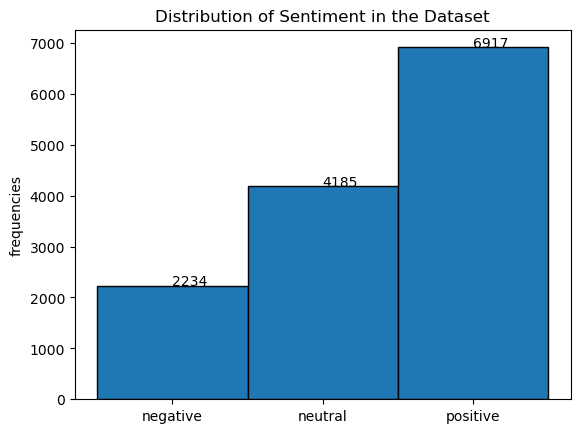

In [9]:
# Plot the distribution of sentiments that have been determined by VADER:
counts = df['Categorization'].value_counts()

# Create a list of labels and counts for each respective class (negative, neutral, and positive)
frequencies = [counts[-1], counts[0], counts[1]]

labels = ["negative", "neutral", "positive"]

# Display Sentiment Distribution in the dataset
plt.bar(range(len(labels)), frequencies, 1, edgecolor=(0,0,0))
plt.title("Distribution of Sentiment in the Dataset")     # add a title
plt.ylabel("frequencies")   # label the y-axis

# label x-axis with label names at bar centers
plt.xticks(range(len(labels)), labels)

for index, value in enumerate(frequencies):
    plt.text(index, value, str(value))
plt.show()

The bar plot shows that VADER determined that most of these comments are positive and neutral and that only a small portion are negative. How do you think this distribution will effect the model's performance?

The next step is splitting the dataset into training and testing sets and preparing the data to train the model. The train_test_split() function from scikit-learn is used for this purpose. It takes the 'stopwords_removed' column as the feature data (x) and the 'Categorization' column as the target variable (y). The dataset is split with a test size of 0.2, meaning 20% of the data will be used for testing, while the remaining 80% will be used for training. The random_state parameter is set to 15 to ensure reproducibility.

Next, the data is vectorized using the CountVectorizer() class from scikit-learn. This step converts the text data into numerical representations that machine learning models can process. The fit_transform() method is applied to the training data (X_train), and the transform() method is applied to the testing data (X_test) using the instantiated vect object.

Then we create a Multinomial Logistic Regression model to handle multiple classes. Depending on your data, you may want to change the parameters for the model. The model is trained on the vectorized training data (tf_train) and the corresponding target variable (y_train) using the fit() method.

In [10]:
# Split the dataset into a testing set and a training set
X_train, X_test, y_train, y_test = train_test_split(df['stopwords_removed'], df['Categorization'], test_size = 0.2, random_state = 15)

# Vectorize the Data
vect = CountVectorizer()
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)

# Create Multinomial Logistic Regression Model (Since dealing with multiple classes)
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=250)
lr.fit(tf_train,y_train)

LogisticRegression(max_iter=250, multi_class='multinomial')

Next we will look at the accuracy of the model. Accuracy provides an overall measure of how well the model performs in predicting sentiment. It allows us to assess the model's effectiveness in correctly classifying comments into the appropriate sentiment categories.

To calculate the accuracy scores, we can use the score() method of the Logistic Regression model lr.

In [11]:
# Print accuracy of self and independent tests.
print("Checking Accuracy of score on both datasets")
print("Accuracy score on training dataset:",round(lr.score(tf_train,y_train), 2))
print("Accuracy score on test dataset:", round(lr.score(tf_test,y_test), 2))


Checking Accuracy of score on both datasets
Accuracy score on training dataset: 0.94
Accuracy score on test dataset: 0.82


While accuracy is a valuable metric for evaluating sentiment analysis models it may not explain everything about the model's performance. Using other metrics and figures such as the confusion matrix and classification report can provide additional insights into the model's performance.

A <b>classification report</b> provides a comprehensive evaluation of a classification model's performance by presenting key metrics such as precision, recall, F1-score, and support for each class. It summarizes the model's ability to accurately classify instances, identify true positives and negatives, and detect false positives and negatives. 

A <b>confusion matrix</b> is a tabular representation that summarizes the performance of a classification model by showing the count of true positive, true negative, false positive, and false negative predictions. It provides a clear overview of how well the model's predictions align with the actual class labels.

We can use the metrics module to do display both of these.

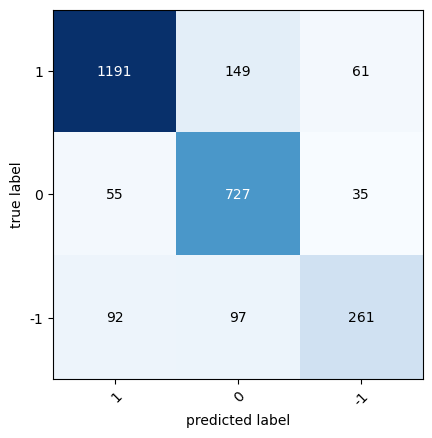

Showing Classification report:
              precision    recall  f1-score   support

          -1       0.73      0.58      0.65       450
           0       0.75      0.89      0.81       817
           1       0.89      0.85      0.87      1401

    accuracy                           0.82      2668
   macro avg       0.79      0.77      0.78      2668
weighted avg       0.82      0.82      0.81      2668

Showing F1 Score:
0.78



In [12]:
# Make predictions on the test dataset
expected = y_test
predicted = lr.predict(tf_test)

#Plot and Display confusion matrix for the test dataset
cf = metrics.confusion_matrix(expected,predicted,labels = [1, 0, -1])
fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1, 0, -1])
plt.show()

print("Showing Classification report:")
# Print classification report
print(metrics.classification_report(expected, predicted))

# Find F1 Score
print("Showing F1 Score:")
print(round(metrics.f1_score(expected, predicted, average='macro'), 2))
print()

For sentiment analysis, you typically want each of your metrics to be at least 80%. The reason being that humans agree on sentiment of text around 80% of the time.

At this point, if you would like to further test the model on new data, you can run this block of code to test your own comments:

In [ ]:
# To test your own comments on the model
while True:
    entry = input("Enter a YouTube comment for sentiment classification: ")

    #Lowercase the input and get rid of whitespace
    entry = entry.lower().strip()
    entry = remove_stopwords(entry)
    tf_test = vect.transform([entry])
    predicted = lr.predict(tf_test)

    if(predicted[0] == 1):
        print("Positive")

    elif(predicted[0] == 0):
        print("Neutral")

    elif(predicted[0] == -1):
        print("Negative")

<div>
<p>In this guide, we have explored the use of VADER in conjunction with a Multinomial Logistic Regression model for sentiment classification in machine learning. We have discussed how to preprocess textual data using natural language processing techniques such as lemmatization and stop word removal. We have built a model using labels assigned by VADER as a feature for machine learning. We have also discussed how to evaluate the model’s performance to see how effective it is for sentiment classification.</p>

<p>Now let’s discuss the strengths and limitations of using this approach. First we will begin with the strengths:</p>
<ul>
<li><p>VADER allows for quick evaluation and scoring of the sentiment in a piece of text. By using VADER to label the dataset according to the sentiment score, we can overcome the challenge of manually labeling a large dataset. This saves time and effort in the labeling process.</p></li>

<li><p>Multinomial Logistic Regression is well-suited for multi-class classification problems. It models the probabilities of multiple classes and finds the best decision boundaries to separate the data into three or more classes. This makes it effective for sentiment classification tasks where we want to classify comments into positive, negative, and neutral categories.</p></li>
</ul>
However, there are also limitations to consider:
<ul>
<li><p>This model can sometimes fail to recognize nuances and intricacies of natural language such as sarcasm and irony since it is rather basic and simple. In its current state it should only perform well for basic sentiment analysis tasks.</p></li>
    
<li><p>This model relies heavily on VADER for labeling the dataset. VADER is a rule-based sentiment analysis tool that has been trained on specific data. While it performs well in many cases, it may not capture all nuances and subtleties of sentiment. It is important to be aware of its limitations and consider alternative sentiment analysis approaches if higher accuracy is required.</p></li>

<li><p>The approach described in this guide is primarily designed for English sentiment analysis. It relies on the assumption that the input comments are in English and may not perform well on comments in other languages. Adapting this method to different languages would require modifications and adjustments.</p></li>
</ul>

<p>It is important to note that this model is in no way perfect or complete. However, it provides a good starting point for creating a general-purpose sentiment analysis application. To enhance the model's performance for domain-specific applications, it is recommended to train the model using domain-specific features in addition to VADER labels. This augmentation would allow the model to better capture nuances and intricacies specific to the target domain, resulting in improved sentiment analysis outcomes.</p>

</div>
<br>